Instructions: click restart and run all above. Figures will show once the entire notebook has finished running

In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

# Cortex straightening

This notebook demonstrates, in detail, the computational methods used in this package to straighten the cortex from images of zygotes. This considerably simplifies the geometry of the object that we are dealing with, and provides an input for further quantification.

### Load image

<IPython.core.display.Javascript object>


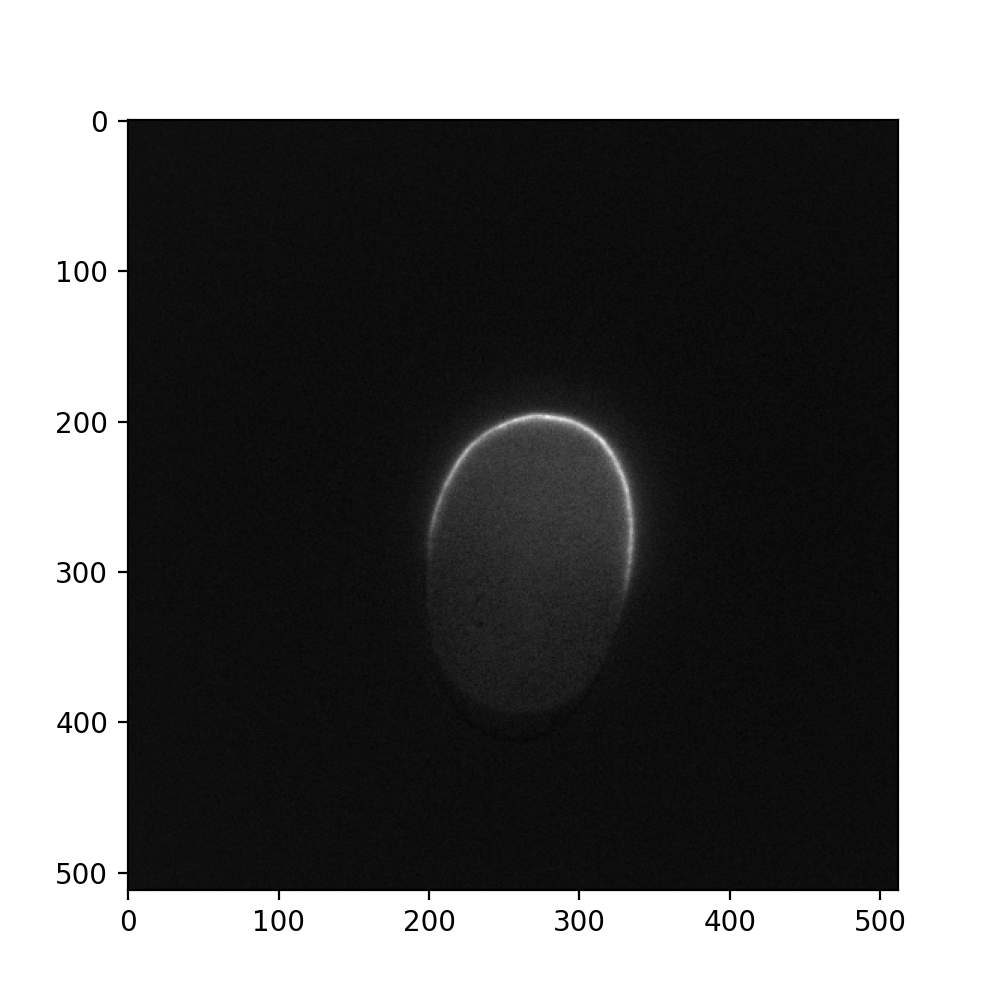

In [2]:
from membranequant.funcs import load_image

path = '../test_datasets/dataset2_par2_neon/01/'
img = load_image(path + '/af_corrected.tif')

fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
fig.set_size_inches(5,5)

### Specify ROI

Can use the def_roi function to manually specify an ROI defining the cortex (or region of the cortex to be straightened). Set periodic=True if the ROI is periodic (i.e. the whole cell circumference). 

NB. This doesn't yet work well in jupyter notebooks. However, we can get a new window to open by specifying the matplotlib tk backend (%matplotlib tk).

Alternatively, we can import a previously defined ROI saved as a txt file.

For quantification purposes, this doesn't have to be precise (a few clicks are usually fine)

In [3]:
# from membranequant.roi import def_roi
# periodic = True
# %matplotlib tk
# roi = def_roi(img, spline=False, periodic=periodic)
# np.savetxt(path + 'ROI_pre-spline.txt', roi)
# %matplotlib inline

roi = np.loadtxt(path + '/ROI_pre-spline.txt')

<IPython.core.display.Javascript object>


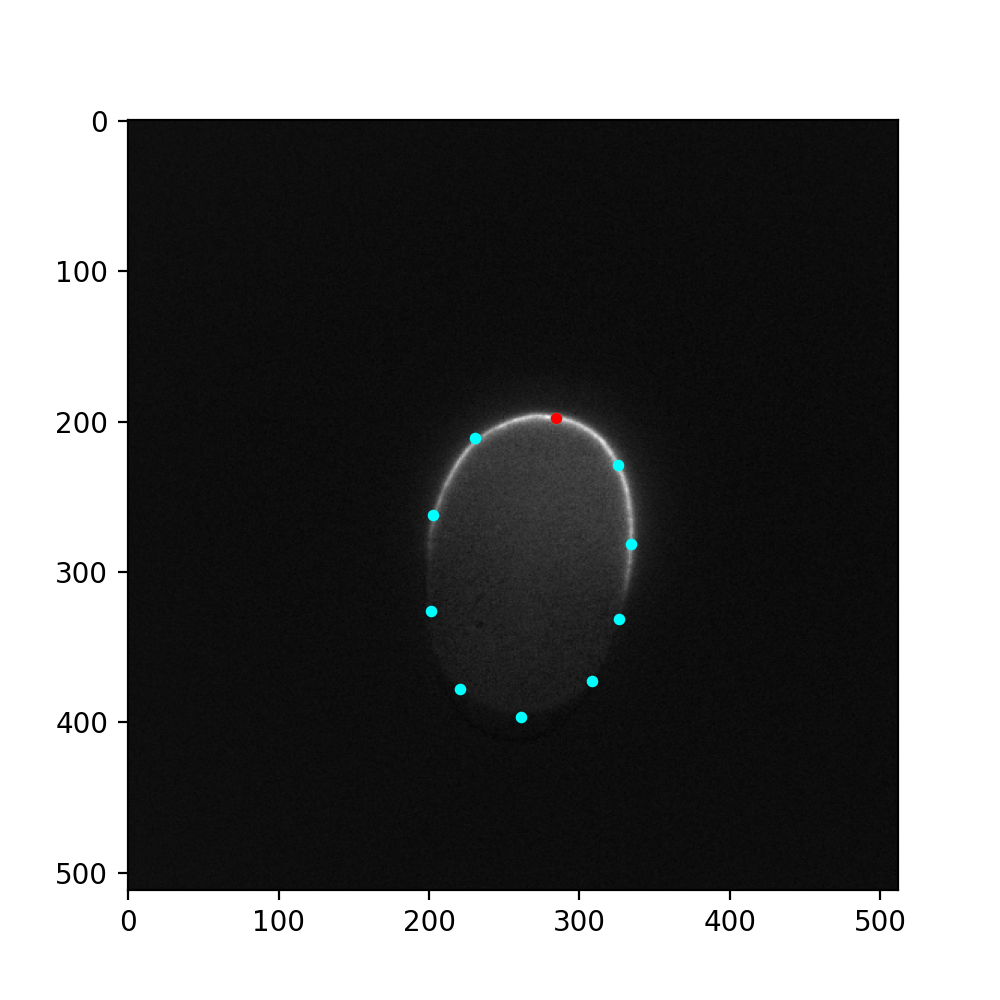

In [4]:
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
ax.scatter(roi[:, 0], roi[:, 1], c='aqua', s=10)
ax.scatter(roi[0, 0], roi[0, 1], c='r', s=10)
fig.set_size_inches(5,5)

### Fit spline to ROI

Fit a spline to the user inputed points, and interpolate coordinates at pixel-length distances.

NOTE this process can be automatically performed when the ROI is defined, by setting spline to True in the def_roi function, but assuming this hasn't been done, this is the code to do it:

In [5]:
from scipy.interpolate import splprep, splev, interp1d

periodic=True

# Append the starting x,y coordinates
if periodic:
    x = np.r_[roi[:, 0], roi[0, 0]]
    y = np.r_[roi[:, 1], roi[0, 1]]
else:
    x = roi[:, 0]
    y = roi[:, 1]

# Fit spline
tck, u = splprep([x, y], s=0, per=periodic)

# Evaluate spline at many points
xi, yi = splev(np.linspace(0, 1, 10000), tck)

# Calculate distance between points in pixel units
distances = ((np.diff(xi) ** 2) + (np.diff(yi) ** 2)) ** 0.5
distances_cumsum = np.r_[0, np.cumsum(distances)]

# Calculate total length of spline
total_length = sum(distances)

# Interpolate to one pixel distances
fx, fy = interp1d(distances_cumsum, xi, kind='linear'), interp1d(distances_cumsum, yi, kind='linear')
positions = np.linspace(0, total_length, int(round(total_length)))
xcoors, ycoors = fx(positions), fy(positions)
roi = np.c_[xcoors[:-1], ycoors[:-1]]
print(roi.shape)

(539, 2)


<IPython.core.display.Javascript object>


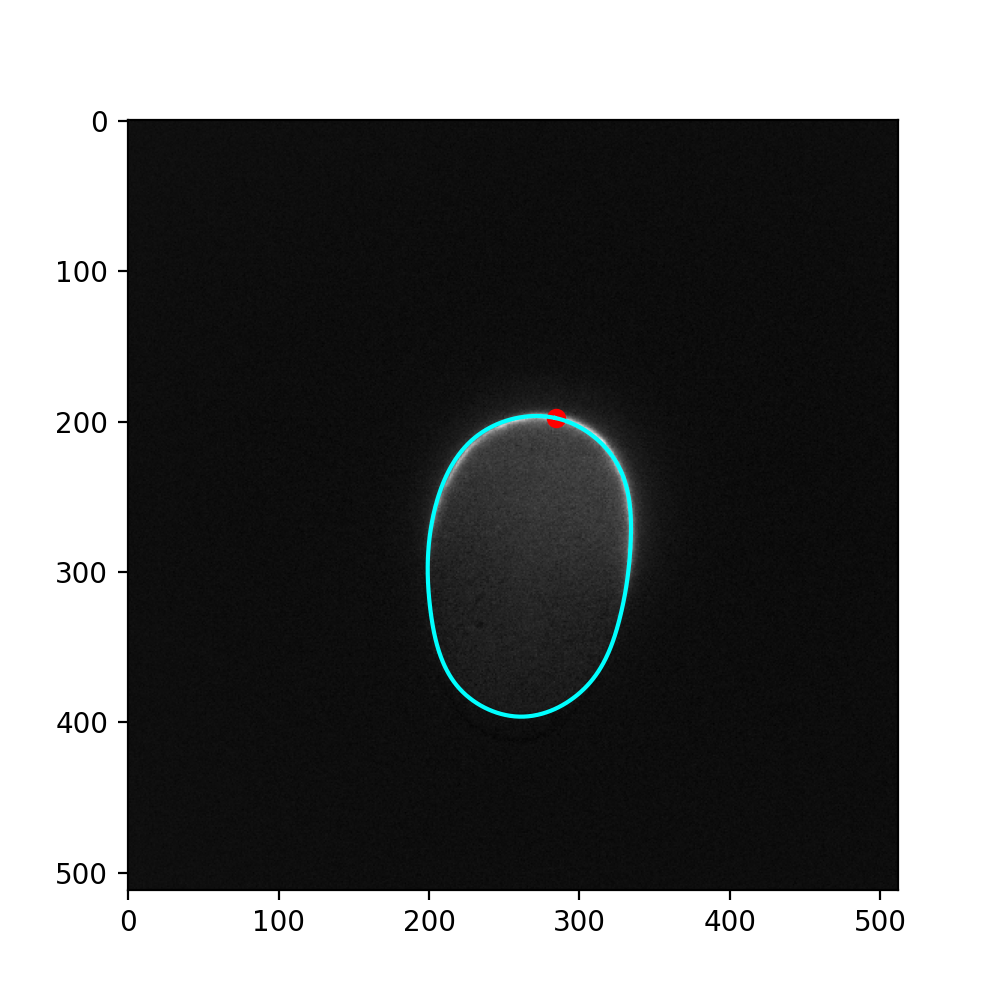

In [6]:
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
ax.plot(roi[:, 0], roi[:, 1], c='aqua')
ax.scatter(roi[0, 0], roi[0, 1], c='r')
fig.set_size_inches(5,5)

### Calculate grid coordinates

We will calculates a grid of coordinate points at which to interpolate the image.

Set the thickness parameter to specify the thickness of the resulting straightened image (50 usually works well for subsequent analysis)

In [7]:
thickness = 50

# Calculate grid
xcoors = roi[:, 0]
ycoors = roi[:, 1]
ydiffs = np.diff(ycoors, prepend=ycoors[-1])
xdiffs = np.diff(xcoors, prepend=xcoors[-1])
grad = ydiffs / xdiffs
tangent_grad = -1 / grad
offsets = np.linspace(thickness / 2, -thickness / 2, thickness)
xchange = ((offsets ** 2)[np.newaxis, :] / (1 + tangent_grad ** 2)[:, np.newaxis]) ** 0.5
ychange = xchange / abs(grad)[:, np.newaxis]
gridcoors_x = xcoors[:, np.newaxis] + np.sign(ydiffs)[:, np.newaxis] * np.sign(offsets)[np.newaxis, :] * xchange
gridcoors_y = ycoors[:, np.newaxis] - np.sign(xdiffs)[:, np.newaxis] * np.sign(offsets)[np.newaxis, :] * ychange

<IPython.core.display.Javascript object>


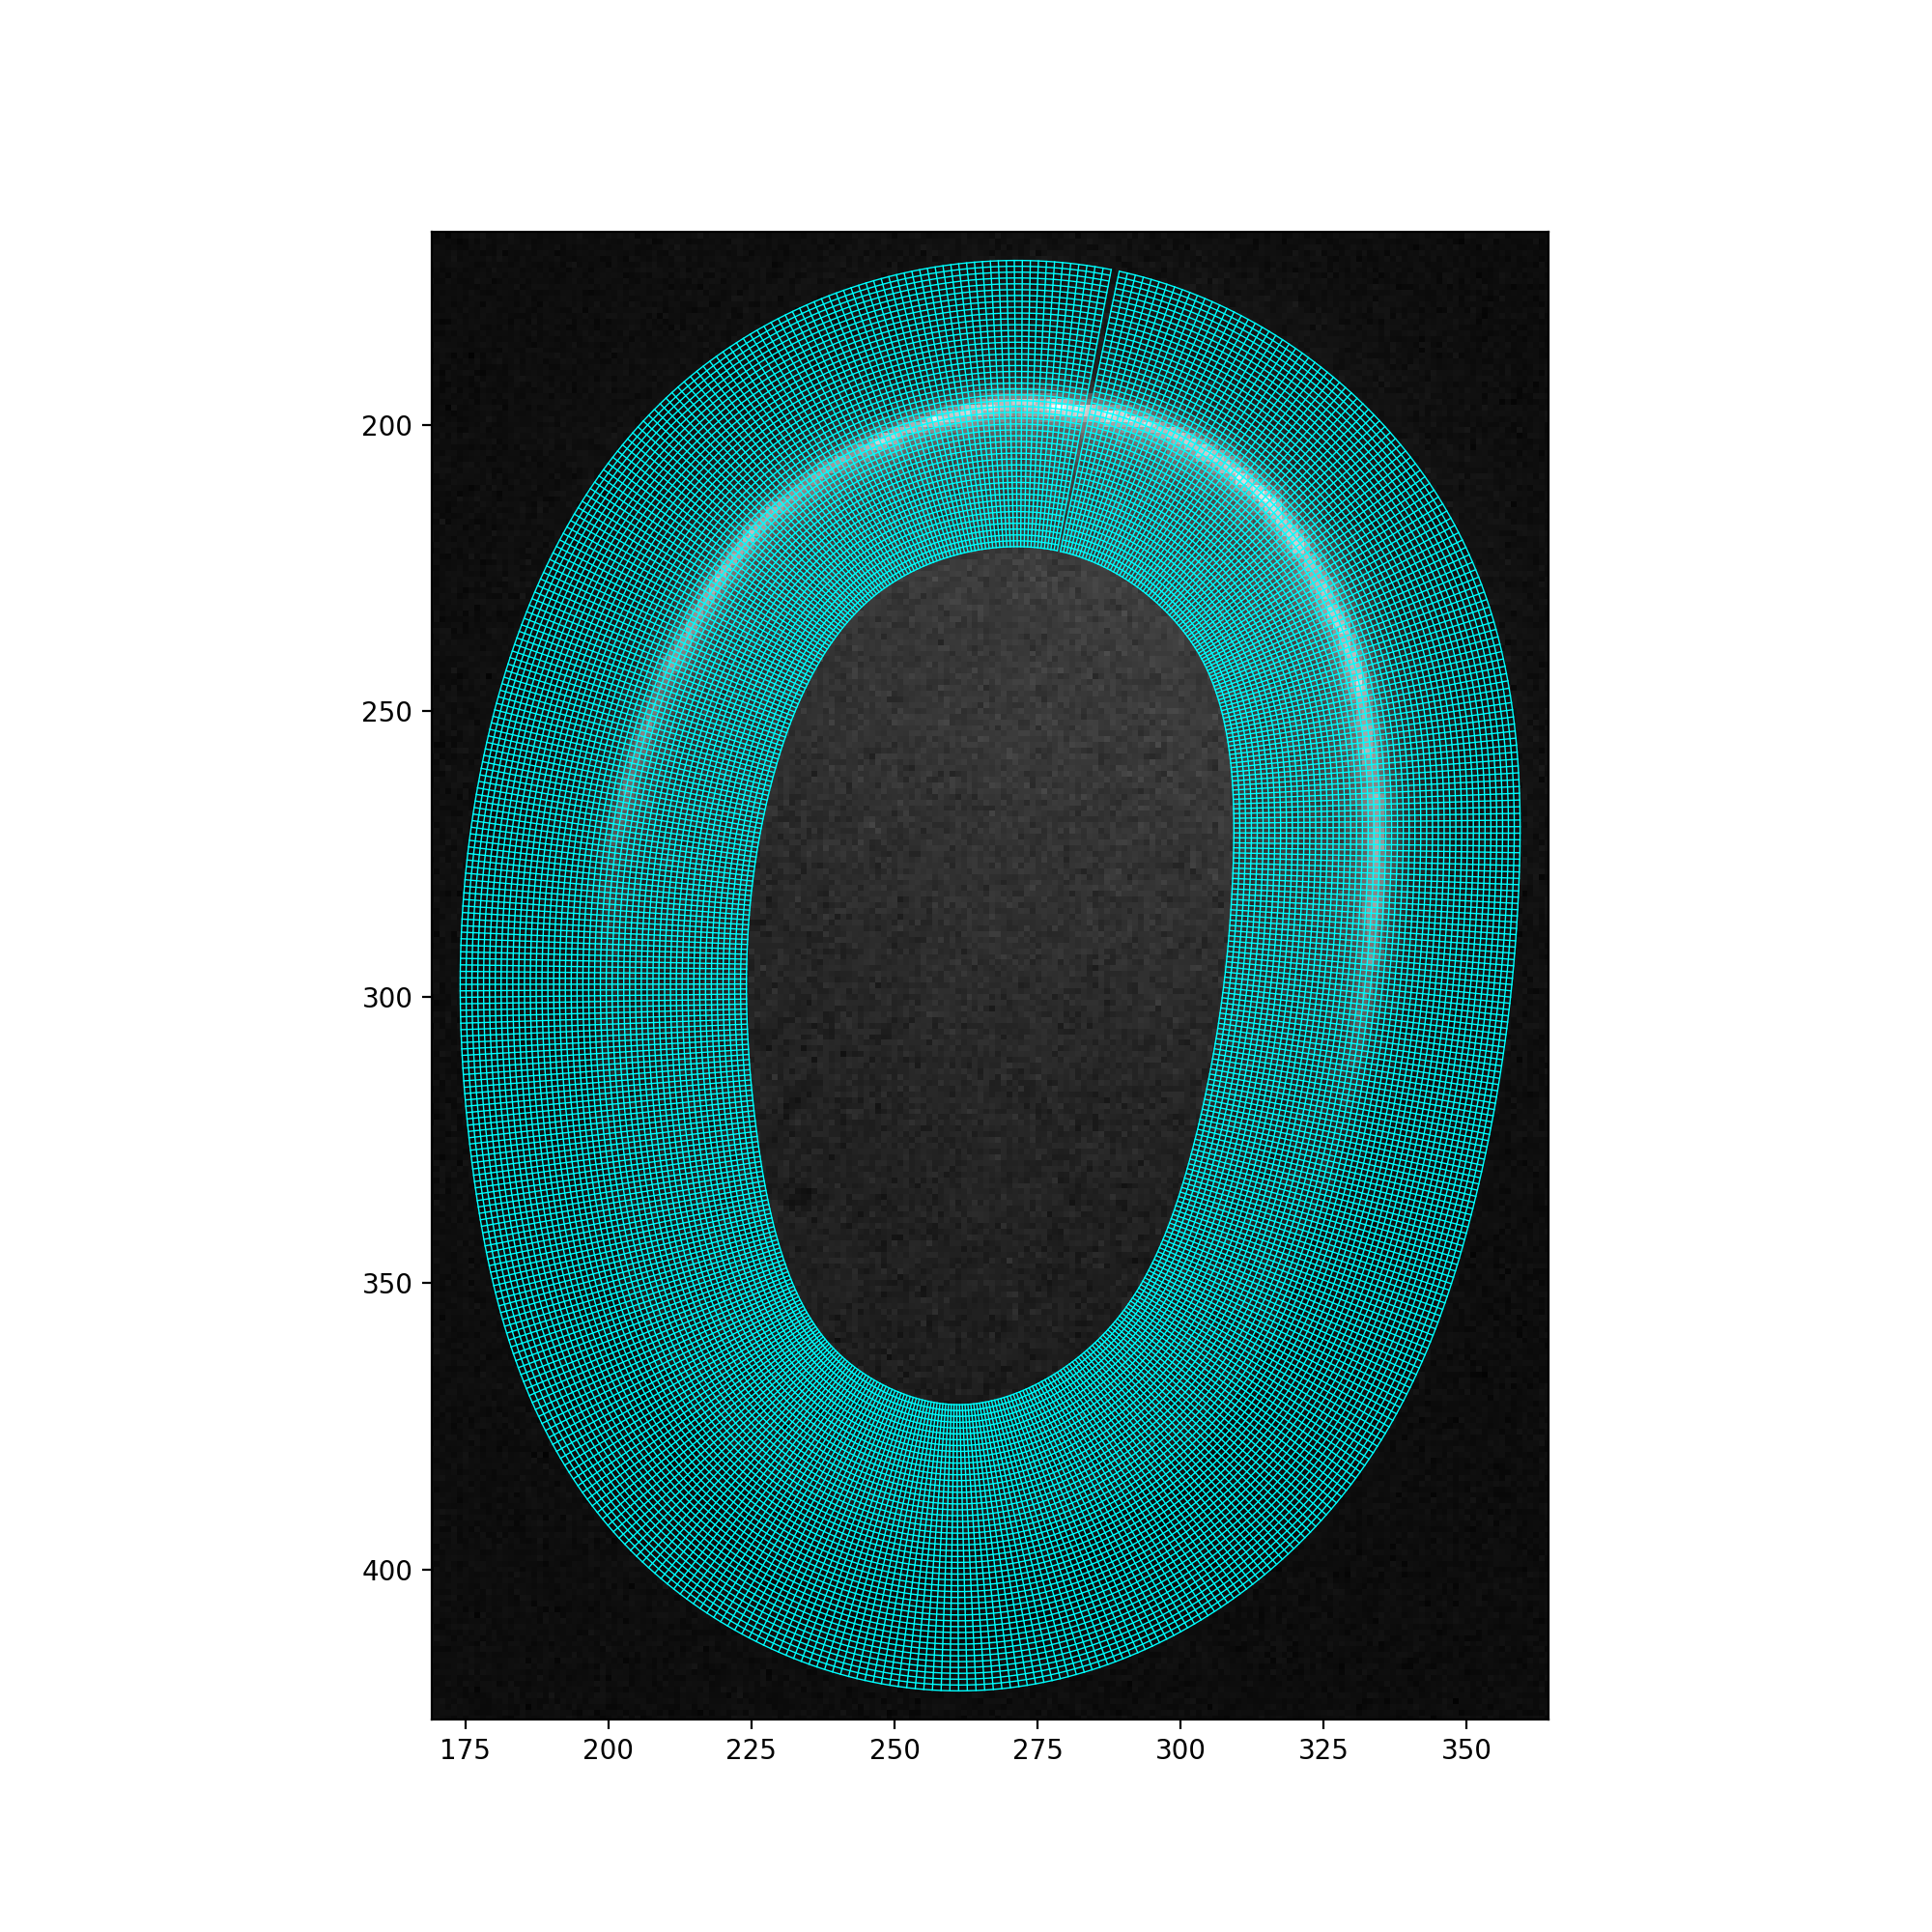

In [8]:
# Plot grid
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
ax.plot(gridcoors_x, gridcoors_y, linewidth=0.5, c='aqua')
ax.plot(gridcoors_x.T, gridcoors_y.T, linewidth=0.5, c='aqua')
ax.set_xlim(np.min(gridcoors_x) - 5, np.max(gridcoors_x) + 5)
ax.set_ylim(np.max(gridcoors_y) + 5, np.min(gridcoors_y) - 5)
fig.set_size_inches(10, 10)


### Get straightened image by interpolation

Using the  map_coordinates function from scipy, we will map the image to the above coordinate grid by interpolation, outputting a straightened image of the cell cortex. Can perform linear interpolation by specifying order = 1, or cubic interpolation by specifying order = 3.

<IPython.core.display.Javascript object>


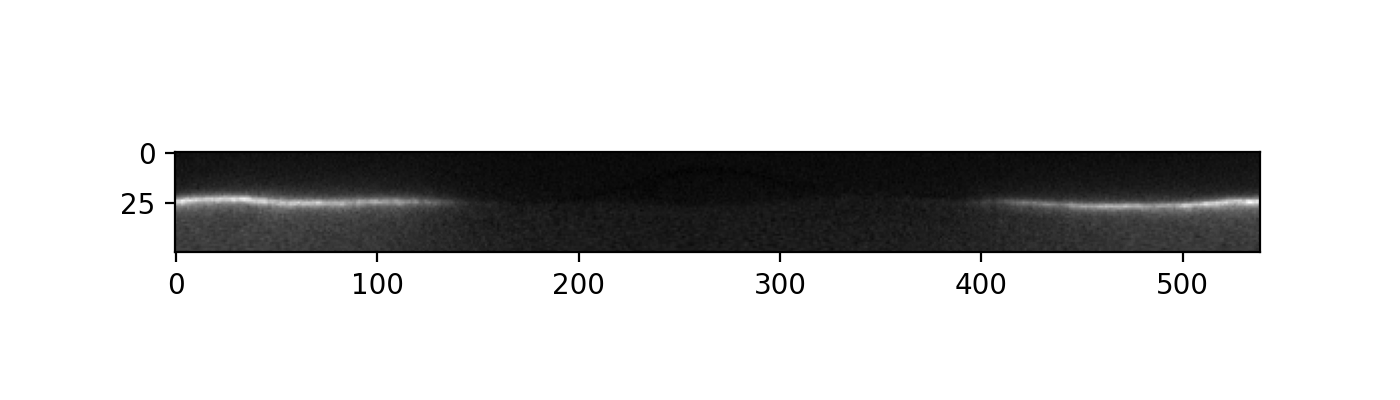

In [9]:
from scipy.ndimage.interpolation import map_coordinates

order = 3
straight_img = map_coordinates(img.T, [gridcoors_x, gridcoors_y], order=3, mode='nearest').T

fig, ax = plt.subplots()
ax.imshow(straight_img, cmap='gray')
fig.set_size_inches(7,2)

# Straighten function

The above operations can be performed in a single line using the straighten function. Thickness and interpolation type (default is cubic), are provided as parameters.

<IPython.core.display.Javascript object>


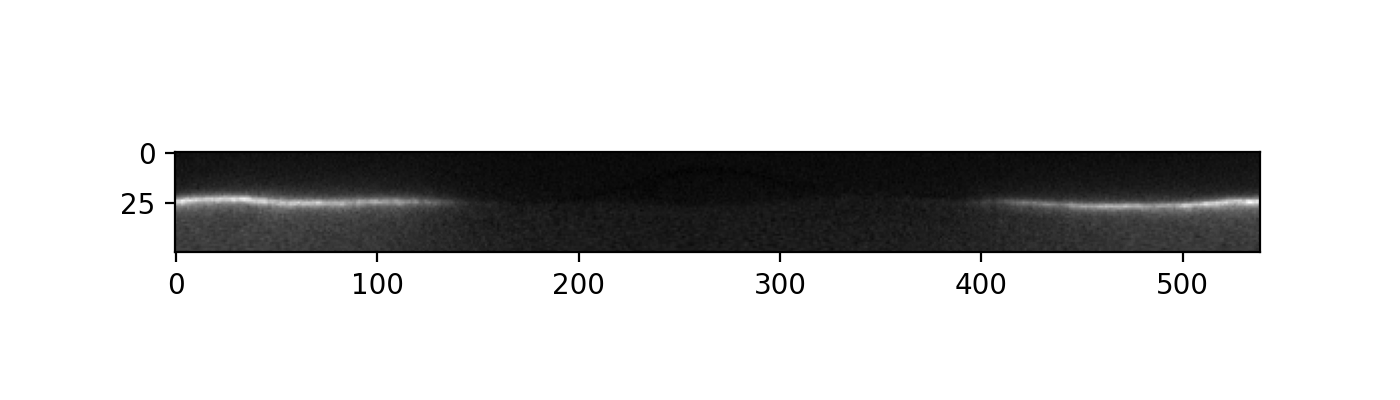

In [10]:
from membranequant.funcs import straighten
straight_img = straighten(img=img, roi=roi, thickness=50, interp='cubic')

fig, ax = plt.subplots()
ax.imshow(straight_img, cmap='gray')
fig.set_size_inches(7, 2)